# Electricity_Forecasting
參考文件: https://docs.google.com/document/d/11G_SqvtPEQD4cqCEfBCpBS4L8BeiVIwlNoXYy7oSdKM/edit  

In [111]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [79]:
'''load data'''
path_file = '台灣電力公司_過去電力供需資訊2021.csv'
past_data = pd.read_csv(path_file)
past_data = pd.DataFrame(past_data)
past_data = past_data.loc[:,['日期','備轉容量(MW)']]
past_data.columns=['date','capacity']
past_data['date']= pd.to_datetime(past_data['date'])

# change datetime format
for index in range(len(past_data['date'])):
    index_time = str(past_data['date'][index]).split('.')[-1][1:]
    # print(index_time)
    time_change = datetime.strptime(index_time,"%Y%m%d")
    past_data['date'][index] = time_change
    past_data['capacity'][index] /= 10 

past_data['year']= pd.DatetimeIndex(past_data['date']).year
past_data['month']= pd.DatetimeIndex(past_data['date']).month
past_data['day']= pd.DatetimeIndex(past_data['date']).day
past_data['day_of_week'] = past_data['date'].dt.dayofweek

today_file =  '台灣電力公司_本年度每日尖峰備轉容量率.csv'
today_data = pd.read_csv(today_file)
today_data = pd.DataFrame(today_data)
today_data = today_data.loc[:,['date','capacity']]
today_data['date'] = pd.to_datetime(today_data['date'])
today_data['year']= pd.DatetimeIndex(today_data['date']).year
today_data['month']= pd.DatetimeIndex(today_data['date']).month
today_data['day']= pd.DatetimeIndex(today_data['date']).day

'''concat two files'''
data_cat = pd.concat([past_data[:365],today_data])

'''split training set and testing set'''
train = data_cat[:-45]
test = data_cat[-45:]

# train.set_index('date',inplace=True)
# test.set_index('date',inplace=True)
# print("train:\n",train)
# print("test:\n",test)

C:\Users\User\AppData\Local\Temp/ipykernel_21604/506383790.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['date'][index] = time_change
C:\Users\User\AppData\Local\Temp/ipykernel_21604/506383790.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['capacity'][index] /= 10


<AxesSubplot:xlabel='date'>

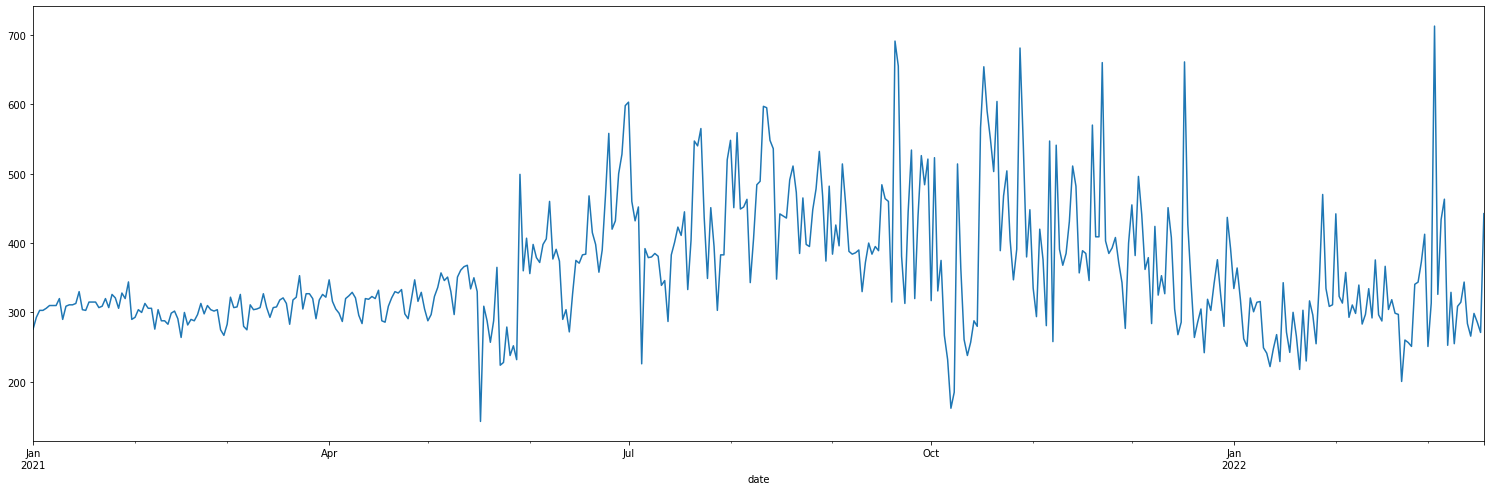

In [80]:
data_cat.set_index('date',inplace=True)
data_cat.head()
data_cat['capacity'].plot(label='first_data', figsize=(26,8))
# data_cat = data_cat.reset_index(level=0)

## xgtboost 演算法
只使用當天的日期

In [27]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

### train

In [29]:
X_train_list =[]
Y_train_list =[]
for i in range(len(train['date'])):
  X = []
  Y = []
  X.extend([train.iloc[i]['year'],train.iloc[i]['month'],train.iloc[i]['day'],train.iloc[i]['day_of_week']])
  # X.append()
  # X.append()
  Y.append(train.iloc[i]['capacity'])
  X_train_list.append(X)
  Y_train_list.append(Y)
X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)
# print(X_list, Y_list)

In [30]:
xgb_model.fit(X_train_list, Y_train_list)

[01:18:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [31]:
y_train_pred = xgb_model.predict(X_train_list)
print(len(y_train_pred))
mse=mean_squared_error(Y_train_list, y_train_pred)
print('train',np.sqrt(mse))

427
train 2.7359749830373805


In [32]:
result_df = train[['date','capacity']]
result_df['capacity_predict'] = y_train_pred
result_df.head()

C:\Users\User\AppData\Local\Temp/ipykernel_21604/4089321974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['capacity_predict'] = y_train_pred


,date,capacity,capacity_predict
0,2021-01-01,276.0,276.002197
1,2021-01-02,293.0,293.884460
2,2021-01-03,303.0,303.165710
3,2021-01-04,303.0,302.848816
4,2021-01-05,306.0,305.601990


In [33]:
result_df.set_index('date',inplace=True)

In [34]:
result_df.head()

,capacity,capacity_predict
date,,
2021-01-01,276.0,276.002197
2021-01-02,293.0,293.884460
2021-01-03,303.0,303.165710
2021-01-04,303.0,302.848816
2021-01-05,306.0,305.601990


<AxesSubplot:xlabel='date'>

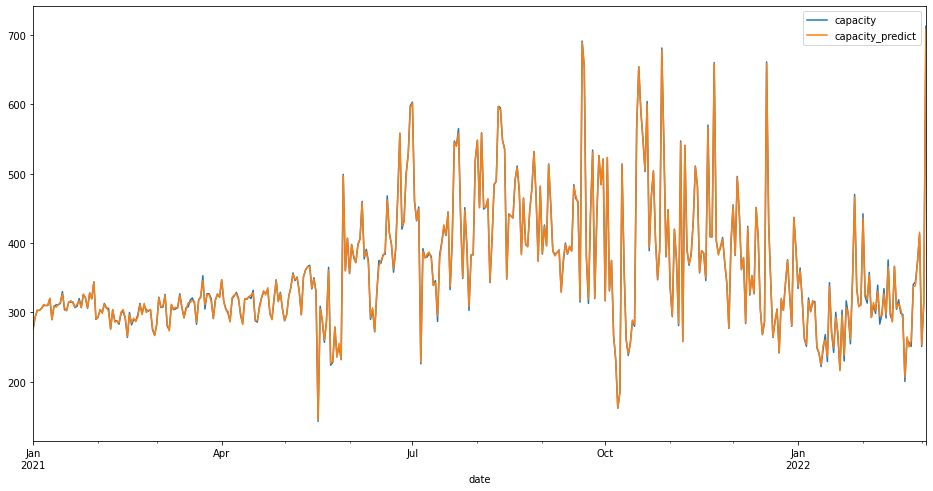

In [35]:
result_df.plot(label='first_data', figsize=(16,8))

In [36]:
result_df = result_df.reset_index(level=0)
result_df.head()

,date,capacity,capacity_predict
0,2021-01-01,276.0,276.002197
1,2021-01-02,293.0,293.884460
2,2021-01-03,303.0,303.165710
3,2021-01-04,303.0,302.848816
4,2021-01-05,306.0,305.601990


### test

In [39]:
X_test_list =[]
Y_test_list =[]

for i in range(len(test['date'])):
  X = []
  Y = []
  X.extend([test.iloc[i]['year'],test.iloc[i]['month'],test.iloc[i]['day'],test.iloc[i]['day_of_week']])
  Y.append(test.iloc[i]['capacity'])
  X_test_list.append(X)
  Y_test_list.append(Y)
X_test_list = np.array(X_test_list)
Y_test_list = np.array(Y_test_list)

In [40]:
y_test_pred = xgb_model.predict(X_test_list)
print(len(y_test_pred))
mse=mean_squared_error(Y_test_list, y_test_pred)
print('test',np.sqrt(mse))

15
test 144.9634980313868


In [41]:
test_result_df = test[['date','capacity']]
test_result_df['capacity_predict'] = y_test_pred
test_result_df.head()

C:\Users\User\AppData\Local\Temp/ipykernel_21604/1548298200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result_df['capacity_predict'] = y_test_pred


,date,capacity,capacity_predict
62,2022-03-04,326.1,586.676758
63,2022-03-05,433.8,444.321930
64,2022-03-06,463.2,439.964600
65,2022-03-07,252.7,437.690002
66,2022-03-08,329.0,459.642273


<AxesSubplot:xlabel='date'>

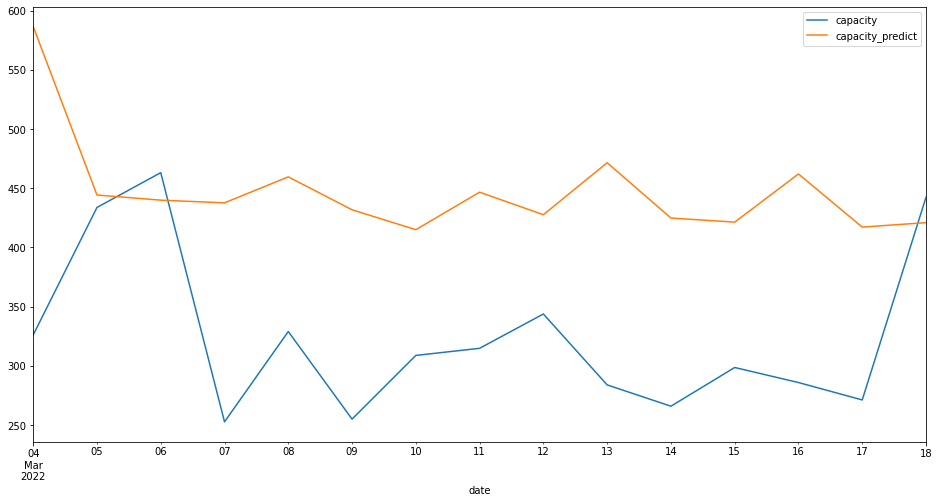

In [42]:
test_result_df.set_index('date',inplace=True)
test_result_df.plot(label='test_data', figsize=(16,8))

## ARIMA 整合移動平均自我迴歸模型

https://adaptable-haze-butterfly-551.medium.com/arima%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E6%A8%A1%E5%9E%8Bpython%E6%87%89%E7%94%A8-%E9%8A%85%E5%83%B9%E6%A0%BC%E9%A0%90%E6%B8%AC-%E4%B8%80-4f91693e3ec6  
時間序列演算法 參考資料：https://blog.csdn.net/weixin_43861350/article/details/110008352#ARIMA__25

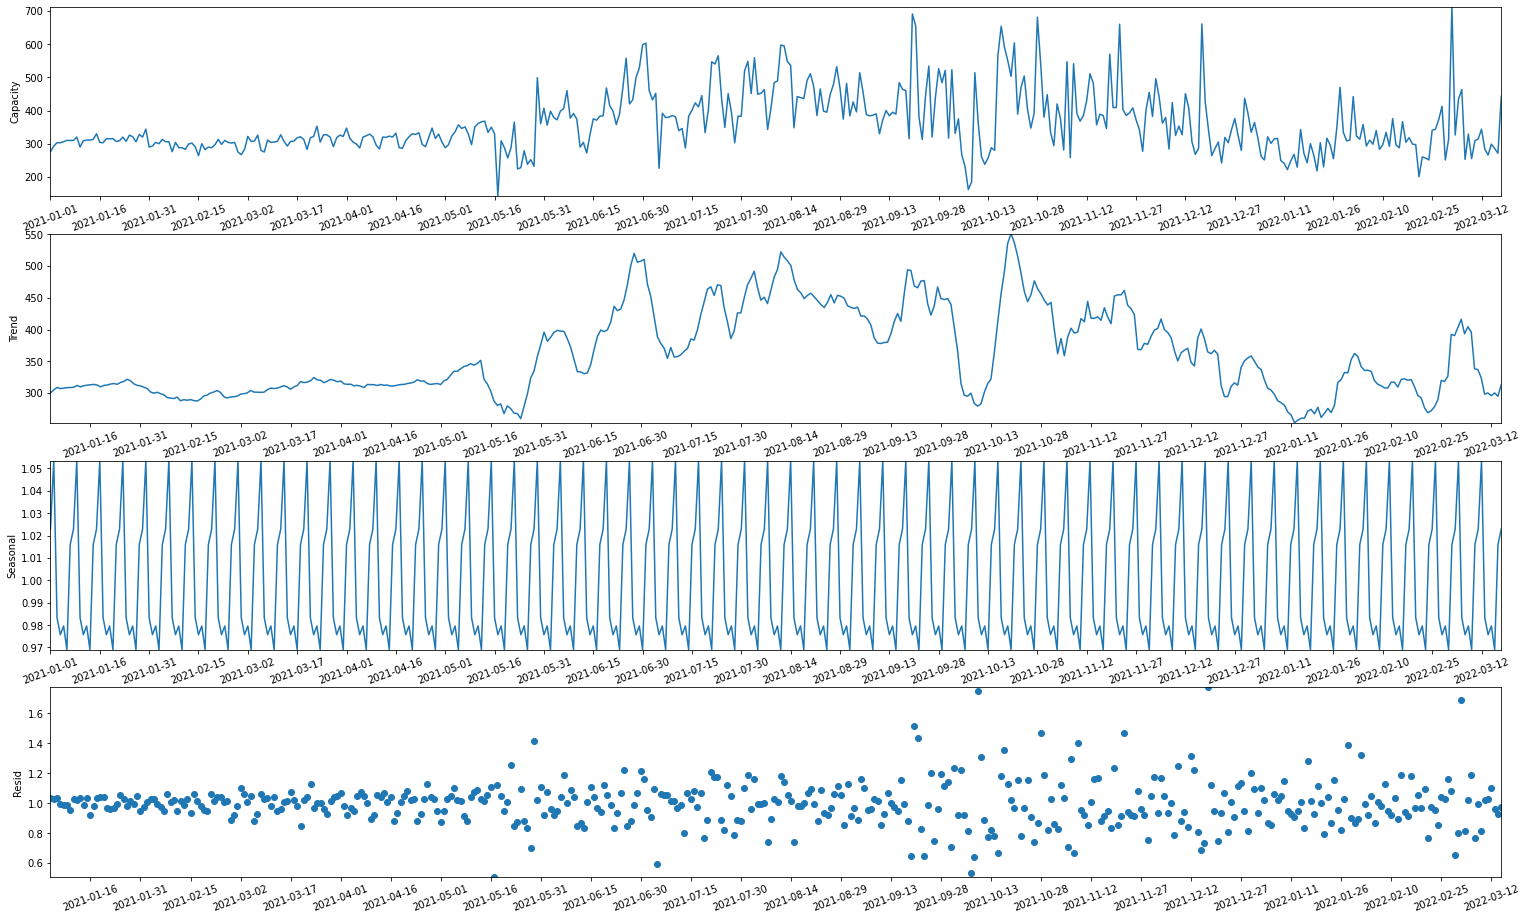

In [105]:
arima_data = data_cat['capacity']
# result = sm.tsa.seasonal_decompose(arima_data) # , freq=3
result = seasonal_decompose(arima_data, model="multiplicative") # , freq=3
plt.figure(figsize=(26,16))
plt.subplot(4,1,1)
plt.plot(result.observed, label="Copper Future")
plt.ylabel("Capacity")
plt.xticks(data_cat.index[::15], rotation=20) #調整x軸刻度的呈現(每隔12個)
plt.margins(0)

plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel("Trend")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)

plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)

plt.subplot(4,1,4)
plt.scatter(data_cat.index,result.resid)
plt.ylabel("Resid")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

In [106]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #寫個自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                  -2.184327
p-value                          0.211983
#Lags Used                      18.000000
Number of Observations Used    423.000000
Criterical Value (1%)           -3.445904
Criterical Value (5%)           -2.868397
Criterical Value (10%)          -2.570423
dtype: float64
The data is non-stationary, so do differencing!


Results of Dickey-Fuller Test
Test Statistic                -8.425181e+00
p-value                        1.935503e-13
#Lags Used                     1.700000e+01
Number of Observations Used    4.230000e+02
Criterical Value (1%)         -3.445904e+00
Criterical Value (5%)         -2.868397e+00
Criterical Value (10%)        -2.570423e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


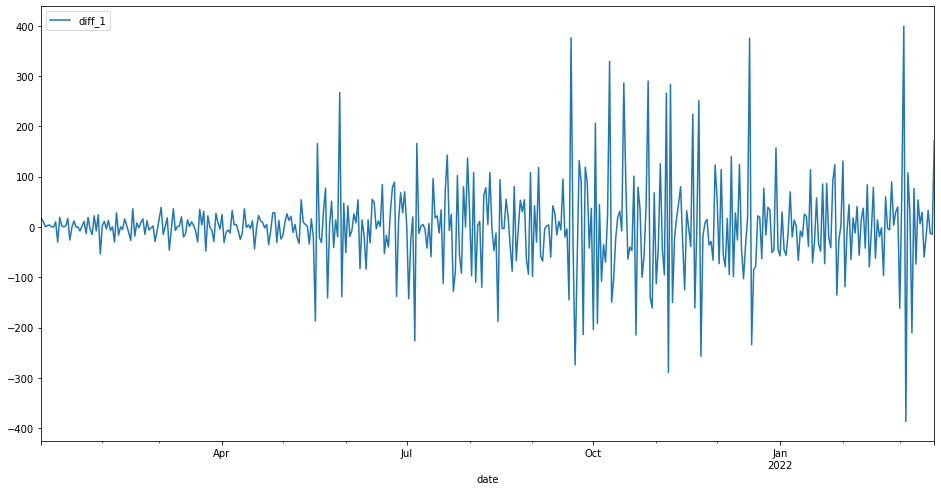

In [95]:
#一階差分 lags:1,12
diff_1 = arima_data - arima_data.shift(1) 
diff_1 = diff_1.dropna()
diff_1.head()
diff_1.plot(figsize=(16,8), label="diff_1")
plt.legend()

adf_test(diff_1)

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


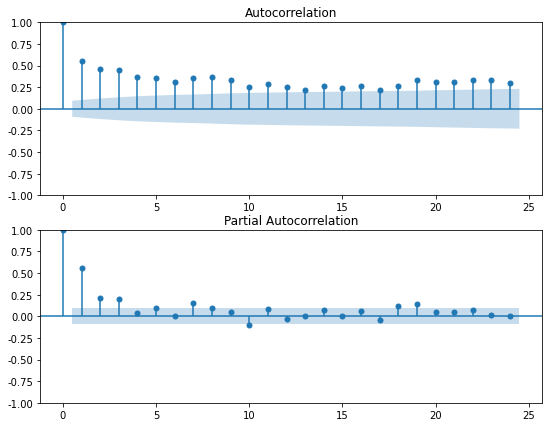

In [97]:
#correlogram
f = plt.figure(facecolor='white', figsize=(9,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data, lags=24, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(arima_data, lags=24, ax=ax2)
plt.rcParams['axes.unicode_minus'] = False 
plt.show()

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packag

ARIMA(0,1,0):AIC=5183.084689761803
ARIMA(0,1,1):AIC=5050.484532209941
ARIMA(0,1,2):AIC=5036.577844779231
ARIMA(1,1,0):AIC=5114.876219328308


C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packag

ARIMA(1,1,1):AIC=5032.133618106603
ARIMA(1,1,2):AIC=5030.501754508912
ARIMA(2,1,0):AIC=5076.46093045364
ARIMA(2,1,1):AIC=5032.128147665139


C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packag

ARIMA(2,1,2):AIC=5032.968413715328
ARIMA(3,1,0):AIC=5072.596768018546


C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packag

ARIMA(3,1,1):AIC=5029.774176439656


C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(3,1,2):AIC=5027.398539569692
This best model is ARIMA(3,1,2) based on argmin AIC.


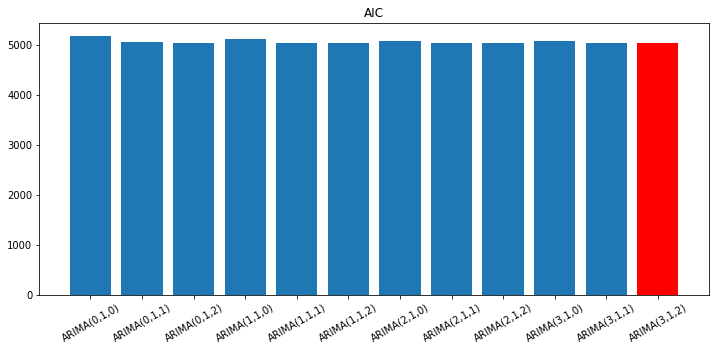

In [108]:
def arima_AIC(data, p=4, d=3, q=4):
    best_AIC =["pdq",10000]
    L =len(data)
    AIC = []
    name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):            
                model = ARIMA(data, order=(i,j,k))
                fitted = model.fit() #disp=-1
                AIC.append(fitted.aic)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k}):AIC={fitted.aic}")
                if fitted.aic < best_AIC[1]:
                    best_AIC[0] = f"ARIMA({i},{j},{k})"
                    best_AIC[1] = fitted.aic
    print("==========================================================================")
    print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    plt.figure(figsize=(12,5))
    plt.bar(name, AIC)
    plt.bar(best_AIC[0], best_AIC[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("AIC")
    plt.savefig("Arima AIC")
    plt.show()
arima_AIC(arima_data, 4,2,3)

C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


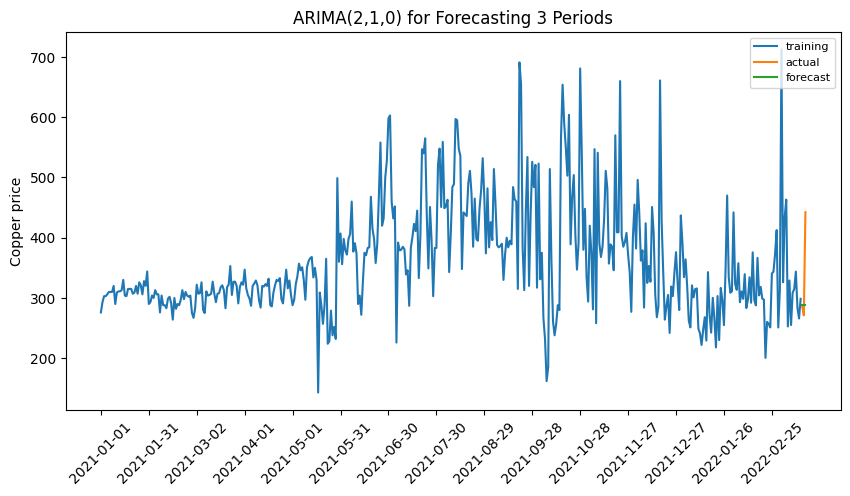

Mean Absolute Error : 57.64203834585445
Mean Squared Error : 8075.917398238577
fc_series: date
2022-03-16    287.626115
2022-03-17    287.626115
2022-03-18    287.626115
dtype: float64
Copper price: date
2022-03-16    285.9
2022-03-17    271.2
2022-03-18    442.4
Name: capacity, dtype: float64


In [120]:
#data spilt
period = 3
title = f'ARIMA(2,1,0) for Forecasting {period} Periods'
L = len(arima_data)
x_train = arima_data[:(L-period)]
x_test = arima_data[-period:]
#Build Model 
model = ARIMA(x_train, order=(2, 1, 0)) 
fitted = model.fit()# disp=-1
#Forecast
fc, se, conf = fitted.forecast(period, alpha=0.05) # 95% conf
#Make as pandas series
fc_series = pd.Series(fc, index=x_test.index)
#Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.xticks(data_cat.index[::30], rotation=45)
plt.title(title)
plt.ylabel("Copper price")
plt.legend(loc='upper right', fontsize=8)
plt.savefig(title)
plt.show()
#Results
print(f"Mean Absolute Error : {mean_absolute_error(fc_series,x_test)}")
print(f"Mean Squared Error : {mean_squared_error(fc_series,x_test)}")
print("===========================") 
print("fc_series:",fc_series)
print("===========================")
print("Copper price:",x_test)